In [1]:
!git clone https://github.com/microsoft/OmniParser.git

Cloning into 'OmniParser'...
remote: Enumerating objects: 1037, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 1037 (delta 221), reused 143 (delta 143), pack-reused 732 (from 2)
Receiving objects: 100% (1037/1037), 50.57 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (536/536), done.


In [ ]:
!cd OmniParser

%cd OmniParser

In [ ]:
%%writefile OmniParser/requirements.txt
torch
easyocr
torchvision
supervision==0.18.0
openai==1.3.5
transformers
ultralytics==8.3.70
azure-identity
numpy==1.26.4
opencv-python
opencv-python-headless
gradio
dill
accelerate
timm
einops==0.8.0
paddlepaddle
paddleocr
ruff==0.6.7
pre-commit==3.8.0
pytest==8.3.3
pytest-asyncio==0.23.6
pyautogui==0.9.54
streamlit>=1.38.0
anthropic>=0.37.1
jsonschema==4.22.0
boto3>=1.28.57
screeninfo
uiautomation
dashscope
groq

In [7]:

!pip install -r requirements.txt


/content/OmniParser
  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached supervision-0.18.0-py3-none-any.whl.metadata (12 kB)
  Using cached openai-1.3.5-py3-none-any.whl.metadata (16 kB)
  Using cached ultralytics-8.3.70-py3-none-any.whl.metadata (35 kB)
  Using cached azure_identity-1.23.0-py3-none-any.whl.metadata (81 kB)
  Using cached gradio-5.31.0-py3-none-any.whl.metadata (16 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached paddlepaddle-3.0.0-cp311-cp311-manylinux1_x86_64.whl.metadata (8.9 kB)
  Using cached paddleocr-3.0.0-py3-none-any.whl.metadata (14 kB)
  Using cached pre_commit-3.8.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached pytest_asyncio-0.23.6-py3-none-any.whl.metadata (3.9 kB)
  Using cached pyautogui-0.9.54-py3-none-any.whl
  Using cached streamlit-1.45.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached anthropic-0.52.0-py3-none-any.whl.meta

In [8]:
%%bash
# make sure we're in the right dir
cd /content/OmniParser

# ensure weights/ exists
mkdir -p weights

# loop over each checkpoint file and download it
for f in \
  icon_detect/train_args.yaml \
  icon_detect/model.pt \
  icon_detect/model.yaml \
  icon_caption/config.json \
  icon_caption/generation_config.json \
  icon_caption/model.safetensors
do
  huggingface-cli download microsoft/OmniParser-v2.0 \
    "$f" --local-dir weights
done

# rename the caption folder to what the code expects
mv weights/icon_caption weights/icon_caption_florence


weights/icon_detect/train_args.yaml
weights/icon_detect/model.pt
weights/icon_detect/model.yaml
weights/icon_caption/config.json
weights/icon_caption/generation_config.json
weights/icon_caption/model.safetensors


Download complete. Moving file to weights/icon_detect/train_args.yaml
Download complete. Moving file to weights/icon_detect/model.pt
Download complete. Moving file to weights/icon_detect/model.yaml
Download complete. Moving file to weights/icon_caption/config.json
Download complete. Moving file to weights/icon_caption/generation_config.json
Download complete. Moving file to weights/icon_caption/model.safetensors


In [9]:
import torch
from util.utils import get_yolo_model

# pick device
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps"   if torch.backends.mps.is_available()
                      else "cpu")
print("Using device:", device)

# load the model
som_model = get_yolo_model("weights/icon_detect/model.pt")

#  ────────────────────────────────────────────────────────────────
# **The key fix: force *all* layers back to float32 before moving to device**
som_model.model = som_model.model.float()    # convert entire nn.Sequential to fp32
som_model = som_model.to(device)              # now safe to send to device
# ────────────────────────────────────────────────────────────────

print("Model dtype after .float():", next(som_model.model.parameters()).dtype)


/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Completedownload https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:15<00:00, 256.60it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 571.18it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 147.49it/s]


Using device: cuda
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model dtype after .float(): torch.float32


In [10]:
import torch

def to_fp32(module: torch.nn.Module):
    # cast parameters and buffers
    for name, param in list(module._parameters.items()):
        if param is not None:
            module._parameters[name] = param.float()
    for name, buf in list(module._buffers.items()):
        if buf is not None:
            module._buffers[name] = buf.float()
    # recurse
    for child in module.children():
        to_fp32(child)
    return module

# load your model
som_model = get_yolo_model("weights/icon_detect/model.pt")

# force entire detector back to float32
som_model.model = to_fp32(som_model.model).to(device)

# sanity check
print("After conversion:", next(som_model.model.parameters()).dtype)  # should be torch.float32


After conversion: torch.float32


In [11]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, ot

In [12]:
# reload utils
import importlib
import utils
importlib.reload(utils)
from PIL import Image
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time()
dino_labeled_img, label_coordinates, parsed_content_list = get_som_labeled_img(
    image_path,
    som_model,
    BOX_TRESHOLD=BOX_TRESHOLD,
    output_coord_in_ratio=True,
    ocr_bbox=ocr_bbox,
    draw_bbox_config=draw_bbox_config,
    caption_model_processor=caption_model_processor,
    ocr_text=text,
    use_local_semantics=True,
    iou_threshold=0.7,
    scale_img=False,
    batch_size=128
)
cur_time_caption = time.time()


image size: (1919, 1079)

0: 736x1280 115 icons, 60.0ms
Speed: 10.1ms preprocess, 60.0ms inference, 368.7ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 128 41
time to get parsed content: 1.14811372756958


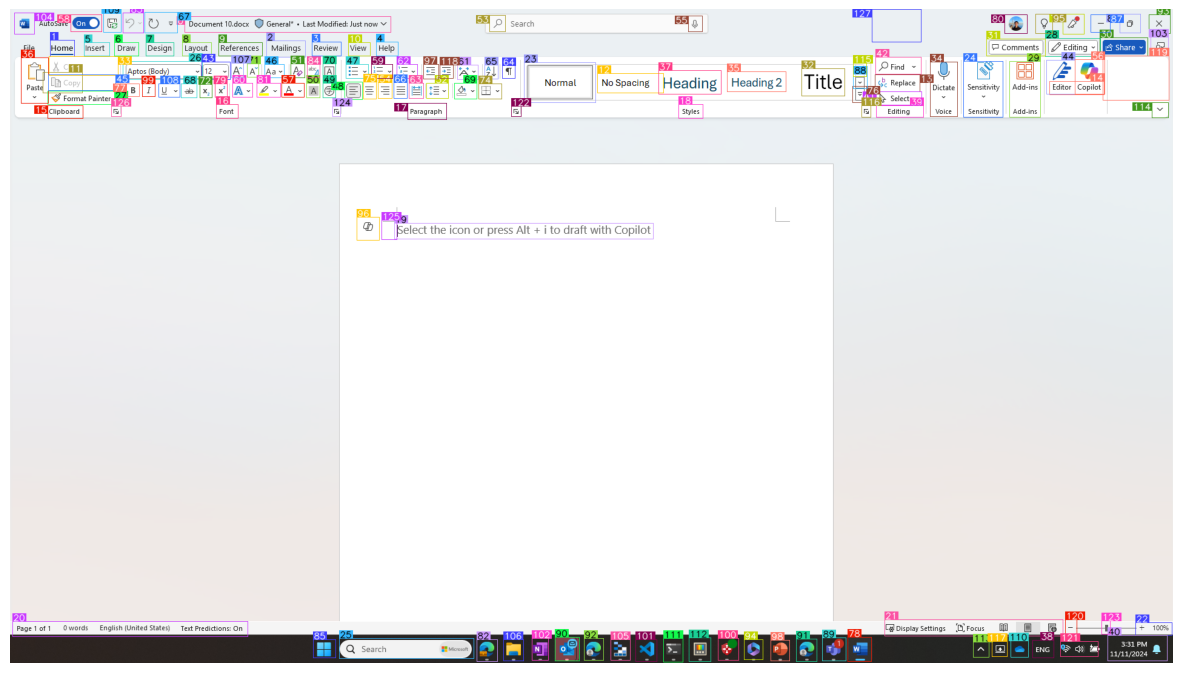

In [13]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labeled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [14]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,box_ocr_content_ocr,0
1,text,"[0.034392911940813065, 0.04726598784327507, 0....",False,Home,box_ocr_content_ocr,1
2,text,"[0.22094841301441193, 0.048192769289016724, 0....",False,Mailings,box_ocr_content_ocr,2
3,text,"[0.2595101594924927, 0.05004633963108063, 0.28...",False,Review,box_ocr_content_ocr,3
4,text,"[0.31474727392196655, 0.05004633963108063, 0.3...",False,Help,box_ocr_content_ocr,4
...,...,...,...,...,...,...
123,icon,"[0.9390138983726501, 0.9358029365539551, 0.946...",True,Adding a new item or element.,box_yolo_content_yolo,123
124,icon,"[0.2776854932308197, 0.14850807189941406, 0.28...",True,Paragraph Options,box_yolo_content_yolo,124
125,icon,"[0.3195074200630188, 0.3229205012321472, 0.332...",True,a blank space.,box_yolo_content_yolo,125
126,icon,"[0.08737807720899582, 0.14849551022052765, 0.0...",True,Paragraph Options,box_yolo_content_yolo,126


In [16]:
!pip install Flask pyngrok==6.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=c0c07fedfc81ddfd079f7c90088195622da04e8cbdf3c5a6aee0ab8f01bfebe4
  Stored in directory: /root/.cache/pip/wheels/b6/2f/3d/4957f583fdfd1c359843d2e57981c634692c579788b2dfc088
Successfully built pyngrok


In [ ]:
import os
import io
import base64
import torch
import numpy as np
from PIL import Image
import gradio as gr

# ———————————————— Your util imports ————————————————
from util.utils import (
    get_yolo_model,
    check_ocr_box,
    get_som_labeled_img,
    get_caption_model_processor
)

# ———————————————— Device + Model Setup ————————————————
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps"  if torch.backends.mps.is_available() else
    "cpu"
)
print("Using device:", device)

# Load and force fp32
som_model = get_yolo_model("weights/icon_detect/model.pt")
som_model.model = som_model.model.float().to(device)

# Caption processor
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)

# Box threshold
BOX_TRESHOLD = 0.05

import traceback


def process_image(input_image: np.ndarray):
    """
    Args:
      input_image: H×W×3 numpy array from Gradio
    Returns:
      annotated PIL image (or None on error),
      parsed_content_list (or {'error': ...} on error)
    """
    temp_path = "/tmp/input.png"
    try:
        # 1) Save incoming image
        img = Image.fromarray(input_image).convert("RGB")
        img.save(temp_path)
        print("[1] Saved image to", temp_path)

        # 2) Try PaddleOCR first
        try:
            (text, ocr_bbox), _ = check_ocr_box(
                temp_path,
                display_img=False,
                output_bb_format="xyxy",
                goal_filtering=None,
                easyocr_args={"paragraph": False, "text_threshold": 0.9},
                use_paddleocr=True
            )
            print("[2] OCR via PaddleOCR succeeded.")
        except Exception as paddle_err:
            print("[2] PaddleOCR failed, falling back to EasyOCR:", paddle_err)
            # fallback to EasyOCR only
            (text, ocr_bbox), _ = check_ocr_box(
                temp_path,
                display_img=False,
                output_bb_format="xyxy",
                goal_filtering=None,
                easyocr_args={"paragraph": False, "text_threshold": 0.9},
                use_paddleocr=False
            )
            print("[2] OCR via EasyOCR succeeded.")

        # 3) Draw‐config
        box_overlay = max(img.size) / 3200
        draw_cfg = {
            "text_scale":    0.8 * box_overlay,
            "text_thickness": max(int(2 * box_overlay), 1),
            "text_padding":   max(int(3 * box_overlay), 1),
            "thickness":      max(int(3 * box_overlay), 1),
        }

        # 4) SOM + caption
        img_b64, coords, parsed = get_som_labeled_img(
            temp_path,
            som_model,
            BOX_TRESHOLD,
            output_coord_in_ratio=True,
            ocr_bbox=ocr_bbox,
            draw_bbox_config=draw_cfg,
            caption_model_processor=caption_model_processor,
            ocr_text=text,
            use_local_semantics=True,
            iou_threshold=0.7,
            scale_img=False,
            batch_size=128
        )
        print("[3] SOM detection + captioning done.")

        # 5) Decode image
        decoded = Image.open(io.BytesIO(base64.b64decode(img_b64)))
        print("[4] Decoded annotated image.")

        # Cleanup
        os.remove(temp_path)
        print("[5] Cleanup done.")

        return decoded, parsed

    except Exception:
        tb = traceback.format_exc()
        print(tb)  # full traceback in Colab logs
        try: os.remove(temp_path)
        except: pass
        return None, {"error": tb}



# ———————————————— Gradio Interface ————————————————
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[
        gr.Image(type="pil", label="Annotated Image"),
        gr.JSON(label="Parsed Content")
    ],
    title="SOM Detector & Captioner API",
    description="Upload an image: returns bounding-box overlay plus parsed content JSON.",
    # Removed server_name and server_port from here
)

# The magic flag: share=True gives you a public URL
if __name__ == "__main__":
    # Added server_name and server_port to the launch method
    iface.launch(share=True, server_name="0.0.0.0", server_port=5500)